In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# When Models hurt prediction : a DC motor trial (p.132/155)

## Définition du modèle et simulation

Modèle sous forme d'espace d'état :

$\begin{cases}
\frac{d}{dt}\begin{bmatrix}i(t)\\
\omega_{R}(t)
\end{bmatrix} & =\begin{bmatrix}-\frac{R}{L} & -\frac{K}{L}\\
\frac{K}{J} & -\frac{f}{J}
\end{bmatrix}\begin{bmatrix}i(t)\\
\omega_{R}(t)
\end{bmatrix}+\begin{bmatrix}\frac{1}{L} & 0\\
0 & -\frac{1}{J}
\end{bmatrix}\begin{bmatrix}V_{S}(t)\\
\tau_{L}(t)
\end{bmatrix}\\
\begin{bmatrix}i_{obs}(t)\\
\omega_{Robs}(t)\\
V_{Lobs}(t)
\end{bmatrix} & =\begin{bmatrix}1 & 0\\
0 & 1\\
-R & -K
\end{bmatrix}\begin{bmatrix}i(t)\\
\omega_{R}(t)
\end{bmatrix}+\begin{bmatrix}0 & 0\\
0 & 0\\
1 & 0
\end{bmatrix}\begin{bmatrix}V_{S}(t)\\
\tau_{L}(t)
\end{bmatrix}
\end{cases}$

In [14]:
def mcc(X,t):
    ##### Etats
    i = X[0]
    w_R = X[1]
    
    ##### Constantes
    R = 1
    K = 1
    L = 1
    J = 1
    f = 1
    
    ##### Entrées
    if t>5:
        V_S = 5
    else:
        V_S = 0.0
    tau_L = 0
    
    ##### ODE's
    didt = -R/L*i -K/L*w_R + 1/L*V_S
    dw_Rdt = K/J*i -f/J*w_R -1/J*tau_L
    dXdt = [didt,dw_Rdt]
    return dXdt

X0 = [0,0]
t = np.linspace(0,20,100)
y = odeint(mcc,X0,t,hmax=0.1)

## Résultats

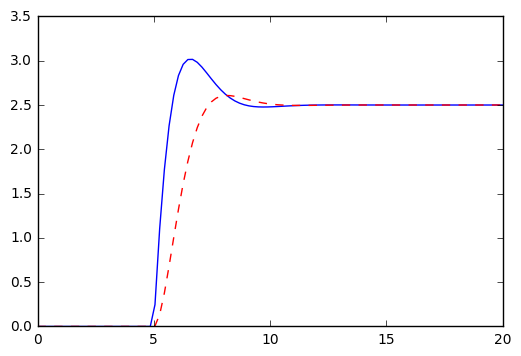

In [16]:
plt.plot(t,y[:,0],'b-');
plt.plot(t,y[:,1],'r--');